## <font color='red'> Code to find the ground state of the Schwinger model using a resource Hamiltonian.   </font>

### <font color='blue'> Classical optimization shows results for the resource Ising Hamiltonian matches with the target Schwinger model Hamiltonian </font>

#### &copy; Abhijit Chakraborty

In [103]:
# Takes the number of lattice sites as input

N = int(input('Enter number of lattice sites: '))

Enter number of lattice sites: 4


In [104]:
# Takes the number of VQE layers as input

layers = int(input('Enter number of layers for VQE: '))

Enter number of layers for VQE: 3


In [105]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [106]:
from numpy import linalg as LA
np.set_printoptions(suppress=True)

In [107]:
size = 2**N

#### The next four cells create the basis in terms of occupation number and spin.

In [108]:
def lattperm(n):
    size = 2**n
    binarr = [None]*size
    
    for i in range(size):
        binarr[i] = bin(i)[2:]
        l = len(binarr[i])
        if l<n:
            for j in range(n-l):
                binarr[i] = '0' + binarr[i]
        binarr[i] = list(map(int,list(binarr[i])))
        
    return binarr

In [109]:
binarr = lattperm(N)

In [110]:
def lat_to_spin(arr):
    n = len(arr)
    spinarr = [[0]*N for _ in range(n)]
    for i in range(n):
        for j in range(N):
            if j%2==0:
                if arr[i][j] == 0:
                    spin = 1
                else:
                    spin = -1
            else:
                if arr[i][j] == 0:
                    spin = -1
                else:
                    spin = 1
            spinarr[i][j] = spin
    return spinarr

In [111]:
spinarr = lat_to_spin(binarr)
#spinarr

In [112]:
def find_off(spinarr,n,i,j):
    tempspin = list(spinarr[n])
    tempspin[j], tempspin[i] = tempspin[i], tempspin[j]
    ind = spinarr.index(tempspin)
    
    return ind

In [113]:
# Defining the Ising Hamiltonian.

def h_ising(J0,spinarr,hmat,B):
    
    for n in range(size):
        for i in range(N-1):
            for j in range(i+1,N):
                if spinarr[n][i]*spinarr[n][j]==-1:
                    ind = find_off(spinarr,n,i,j)
                    hmat[n][ind] = J0/abs(i-j)**2
                    hmat[ind][n] = J0/abs(i-j)**2
        hmat[n][n] = B*sum(spinarr[n])
    return

In [114]:
# Creates the Ising Hamiltonian with the flipflop and rotation terms. To put B = 0, change the last argument to 0.

hmat = np.zeros((size,size))
h_ising(1.0,spinarr,hmat,1.0)

In [115]:
from scipy.linalg import expm

In [116]:
# Creates the matrix exp(-i theta H_ising)

def unitary_ising(theta,hmat):
    unitary_mat = expm(-1j*theta*hmat)
    return unitary_mat

In [117]:
# Creates the single rotation matrix U_z(theta)

def single_rot(theta):
    sigmaz = np.array([[1,0],[0,-1]])
    return expm(-1j*(theta/2)*sigmaz)

In [118]:
# Creates the layer with local rotations on N qubits

def all_single_rot(params):
    num = len(params)
    temp = single_rot(params[0])
    for i in range(1,num):
        temp = np.kron(temp,single_rot(params[i]))
    return temp   

In [119]:
# Creates a layer of unitary evolution with Ising hamiltonian and sigma_z rotations. Has (N/2+1) parameters.

def single_layer(params,hmat):
    theta = params[0]
    ising = unitary_ising(theta,hmat)
    rot = all_single_rot(params[1:])
    return np.matmul(rot,ising)

### Creating the total unitary matrix $U(\theta_i)$ that will act on $|\psi(0)\rangle$

In [120]:
# This function produces the final state of the VQE circuit after all gates are carried out.

def resource_state(thetas):
    length = len(thetas)
    temp = np.eye(size)
    for i in range(1,layers+1):
        start = int((length/layers)*(i-1))
        end = int((length/layers)*i)
        params = np.append(thetas[start:end],thetas[start+1:end][::-1]*(-1))
        #print(params)
        temp = np.matmul(single_layer(params,hmat),temp)
    initial_state = np.zeros(size)
    initial_state[0] = 1
    final_state = np.matmul(temp,initial_state)
    
    return final_state

### Target hamiltonian to calculate the cost function

In [121]:
def hamiltonianM(m,spinstr):
    eng = 0
    for i in range(1,N+1):
        
        if i%2==1:
            eng += -(m/2)*spinstr[i-1]
        else:
            eng += (m/2)*spinstr[i-1]
    
    return eng + m*N/2

In [122]:
def HZJ(J,spinstr):
    tot = 0
    for n in range(1,N):
        sigma_z = 0
        if n%2 == 1:
            for j in range(n):
                sigma_z += spinstr[j]
        tot += sigma_z
        
    return tot*J/2.0

In [123]:
def corrHam(J,spinstr):
    tot = 0
    for n in range(1,N-1):
        for l in range (n+1,N):
            tot += J*(N-l)*spinstr[n-1]*spinstr[l-1]/2
    return tot

In [124]:
def energy_diag(m,J,spinarr,hm):
    size = 2**N
    for i in range(size):
        hm[i][i] = corrHam(J,spinarr[i]) + hamiltonianM(m,spinarr[i]) - HZJ(J,spinarr[i])
        
    return  

In [125]:
def find_ind(spinarr,n,i):
    tempspin = list(spinarr[i])
    tempspin[n], tempspin[n+1] = tempspin[n+1], tempspin[n]
    j = spinarr.index(tempspin)
    
    return j

In [126]:
def flipflop(w,spinarr,hm):
    
    for i in range(size):
        for j in range(N-1):
            if spinarr[i][j]*spinarr[i][j+1]==-1:
                ind = find_ind(spinarr,j,i)
                hm[i][ind] = w
    return

### Cost function (energy expectation) calculation and order parameter definition

In [127]:
def energy_exp(thetas):
    
    final_state = resource_state(thetas)
    temp1 = np.matmul(htarget,final_state)
    temp2 = np.real(np.dot(np.conj(final_state),temp1))
    
    return temp2

In [128]:
def order_param(spinstr):
    tot = 0.0
    for i in range(N):
        if (i+1)%2==0:
            fterm = 1 + spinstr[i]
        else:    
            fterm = 1 - spinstr[i]
        for j in range(i+1,N):
            if (j+1)%2==0:
                sterm = 1 + spinstr[j]
            else:    
                sterm = 1 - spinstr[j] 
            tot += fterm*sterm
            
    return tot/(2*N*(N-1))

### VQE optimization steps

In [129]:
from scipy.optimize import minimize

In [130]:
from scipy.optimize import differential_evolution

Here for the classical optimization I have used the differential evolution algorithm as the minimize function with BFGS algorithm was not giving a good optimization result in the full region. However, the differential evolution algorithm is time-taking whereas the BFGS method is much much faster. To see the results of the BFGS method comment the line 'res = differential_evolution(..)' and uncomment the two lines before that.

In [131]:
bounds = [(-np.pi,np.pi) for i in range((int(N/2)+1)*layers)]

In [132]:
mvals = np.linspace(5,-5,num=10)
order_list = []
occupation_list = []
thetas = np.array([random.uniform(0,1) for i in range((int(N/2)+1)*layers)])
for m in mvals:
    w = 1.0
    J = 1.0
    htarget = np.zeros((size,size))
    energy_diag(m,J,spinarr,htarget)
    flipflop(w,spinarr,htarget)
    #thetas = np.array([random.uniform(0,1) for i in range((int(N/2)+1)*layers)])
    # res = minimize(energy_exp,thetas,method = 'BFGS')
    res = differential_evolution(energy_exp, bounds)
    vec = resource_state(res.x)
    tot = 0.0
    occ = 0.0
    for i in range(size):
        tot += order_param(spinarr[i])*abs(vec[i])*abs(vec[i])
        occ += sum(binarr[i])*abs(vec[i])*abs(vec[i])
    order_list.append(tot) 
    occupation_list.append(occ)
    #thetas = res.x + np.array([random.uniform(-0.1,0.1) for i in range((int(N/2)+1)*layers)]) 

### Plot of the order parameter and occupation number with bare mass

In [133]:
plt.rcParams.update({'font.size': 14, 'font.weight':'normal', 'font.family': 'sans-serif'})

Text(0, 0.5, 'Order parameter')

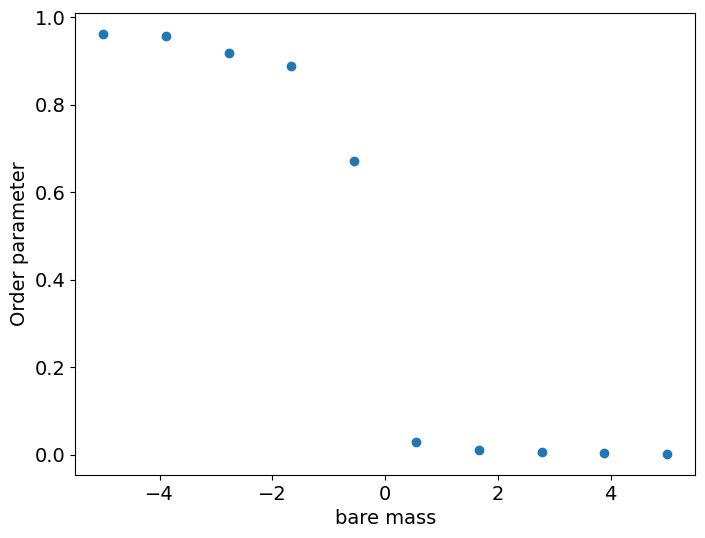

In [134]:
plt.figure(figsize=(8,6))
plt.plot(mvals,order_list,'o')
plt.xlabel('bare mass')
plt.ylabel('Order parameter')

Text(0, 0.5, 'Occupation Number')

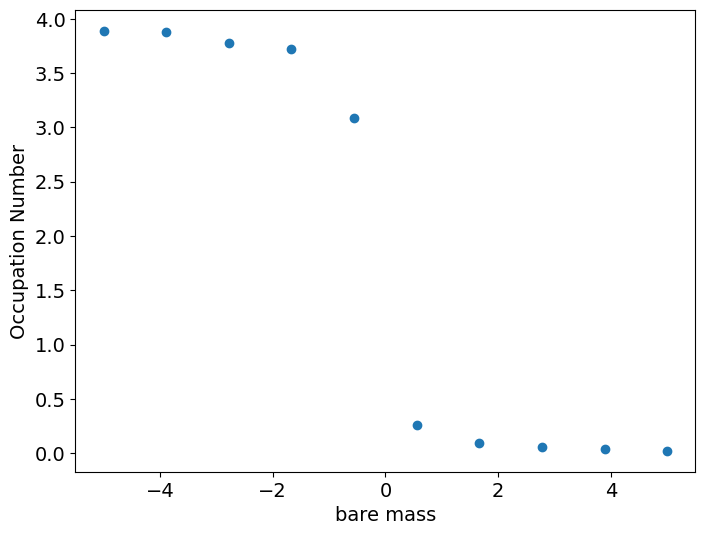

In [135]:
plt.figure(figsize=(8,6))
plt.plot(mvals,occupation_list,'o')
plt.xlabel('bare mass')
plt.ylabel('Occupation Number')

## Exact diagonalization and VQE together

In [136]:
def ground_state(ht):
    w, v = LA.eig(ht)
    min_eig = min(w)
    ind = np.where(w==min_eig)[0][0]
    
    return min_eig, v[:,ind]

In [137]:
order_list_ED = []
occupation_list_ED = []
mvals2 = np.linspace(-5,5,num=50)
for m in mvals2:
    w = 1.0
    J = 1.0
    htarget = np.zeros((size,size))
    energy_diag(m,J,spinarr,htarget)
    flipflop(w,spinarr,htarget)
    eig, vec = ground_state(htarget)
    #print(vec)
    tot = 0.0
    occ = 0.0
    for i in range(size):
        tot += order_param(spinarr[i])*vec[i]*vec[i]
        occ += sum(binarr[i])*vec[i]*vec[i]
    order_list_ED.append(tot) 
    occupation_list_ED.append(occ)

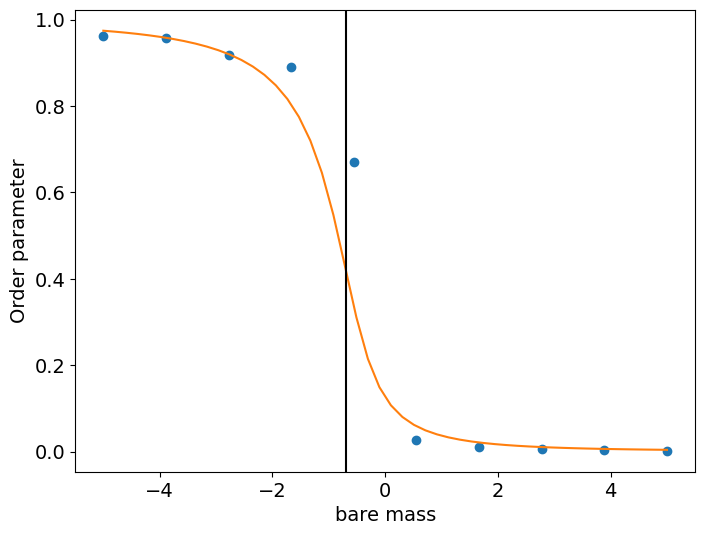

In [139]:
plt.figure(figsize=(8,6))
plt.plot(mvals,order_list,'o')
plt.plot(mvals2,order_list_ED,'-')
plt.axvline(x=-0.7,color='black')
plt.xlabel('bare mass')
plt.ylabel('Order parameter')
#plt.savefig('order_parameter_ED_vs_VQE.png')

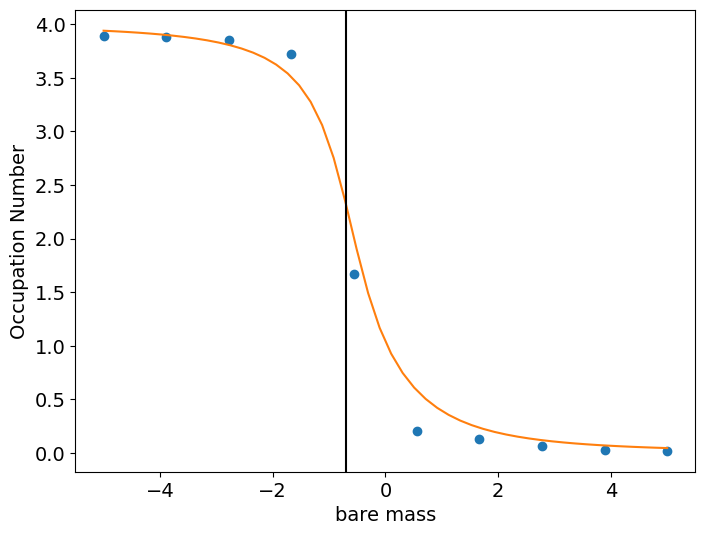

In [77]:
plt.figure(figsize=(8,6))
plt.plot(mvals[::-1],occupation_list,'o')
plt.plot(mvals2,occupation_list_ED,'-')
plt.axvline(x=-0.7,color='black')
plt.xlabel('bare mass')
plt.ylabel('Occupation Number')
#plt.savefig('Occupation_Number_ED_vs_VQE.png')